# GAN Project

### Question 1
### Mixture of Gaussians

In this question we will generate samples from a distibution of a mixture of gaussian distributions anf then train a GAN model on those samples.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

In [2]:
mu1 = torch.tensor([0, 0], dtype=torch.float32)
mu2 = torch.tensor([2, 2], dtype=torch.float32)
mu3 = torch.tensor([-2, 2], dtype=torch.float32)
sigma = 2.0

num_samples = 10000
num_generated = 3000

samples = ((mu1 + sigma*torch.randn(num_samples, 2)) + (mu2 + sigma*torch.randn(num_samples, 2)) + (mu3 + sigma*torch.randn(num_samples, 2)))/np.sqrt(3)

print(samples.shape)

torch.Size([10000, 2])


Now let us make the generator and discrimiator functions for the GAN model

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),      
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Now let us proceed to training the models on the samples generated.

In [4]:
generator = Generator()
discriminator = Discriminator()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [5]:
epochs = 5000
batch_size = 64
real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)
losses_g = []
losses_d = []
k = 5

for epoch in range(epochs):

    #Discriminator Optimization
    
    for _ in range(k):
        optimizer_d.zero_grad()
        real_data = samples[torch.randint(0, num_samples, (batch_size,))]
        real_output = discriminator(real_data)
        real_loss = criterion(real_output, real_labels)

        noise = torch.randn(batch_size, 100)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data.detach())
        fake_loss = criterion(fake_output, fake_labels)

        total_loss_d = real_loss + fake_loss
        total_loss_d.backward()
        optimizer_d.step()


    #Generator Optimization
    optimizer_g.zero_grad()
    fake_output = discriminator(fake_data)
    gen_loss = criterion(fake_output, real_labels)
    gen_loss.backward()
    optimizer_g.step()

    losses_g.append(gen_loss.item())
    losses_d.append(total_loss_d.item())

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}] - Discriminator Loss: {total_loss_d.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

/home/vedansh/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/5000] - Discriminator Loss: 1.3825, Generator Loss: 0.6834
Epoch [100/5000] - Discriminator Loss: 0.8232, Generator Loss: 1.0354
Epoch [200/5000] - Discriminator Loss: 0.9956, Generator Loss: 1.2049
Epoch [300/5000] - Discriminator Loss: 1.2525, Generator Loss: 1.0835
Epoch [400/5000] - Discriminator Loss: 1.1948, Generator Loss: 0.9699
Epoch [500/5000] - Discriminator Loss: 1.1353, Generator Loss: 0.9271
Epoch [600/5000] - Discriminator Loss: 1.2343, Generator Loss: 0.8350
Epoch [700/5000] - Discriminator Loss: 1.4154, Generator Loss: 0.7123
Epoch [800/5000] - Discriminator Loss: 1.4123, Generator Loss: 0.7080
Epoch [900/5000] - Discriminator Loss: 1.3903, Generator Loss: 0.7014
Epoch [1000/5000] - Discriminator Loss: 1.3742, Generator Loss: 0.6994
Epoch [1100/5000] - Discriminator Loss: 1.4000, Generator Loss: 0.6957
Epoch [1200/5000] - Discriminator Loss: 1.3899, Generator Loss: 0.6975
Epoch [1300/5000] - Discriminator Loss: 1.3837, Generator Loss: 0.7105
Epoch [1400/5000] 

Now we will plot the loss vs epoch plots.

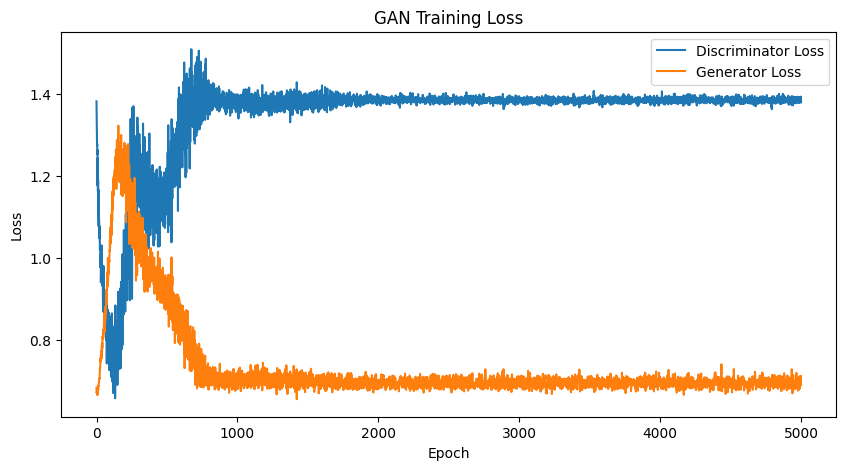

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(losses_d, label="Discriminator Loss")
plt.plot(losses_g, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()

Now let us generate 3000 samples using our trained GAN

In [7]:
generator.eval()
generated_data = generator(torch.randn(num_generated, 100)).detach().numpy()

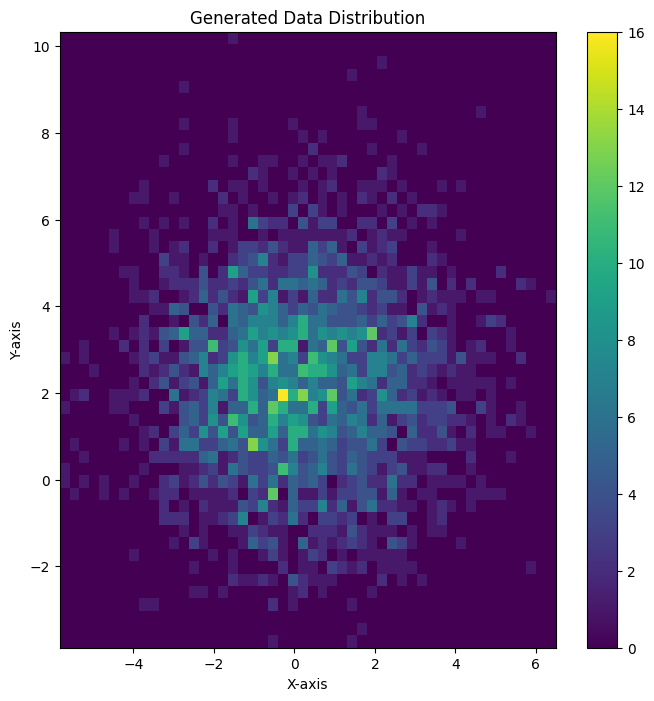

In [8]:
plt.figure(figsize=(8, 8))
plt.hist2d(generated_data[:, 0], generated_data[:, 1], bins=50, cmap='viridis')
plt.title("Generated Data Distribution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar()
plt.show()

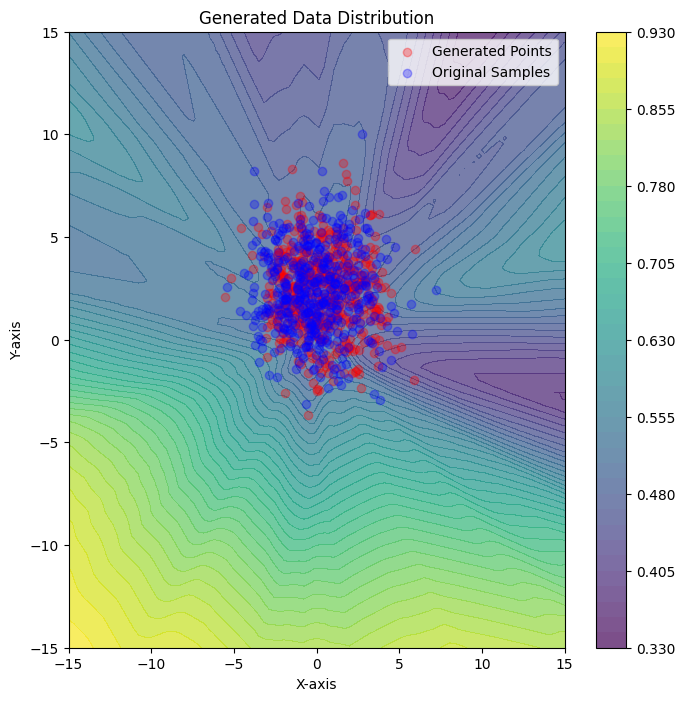

In [9]:
plt.figure(figsize=(8, 8))
plt.title("Generated Data Distribution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.flatten(), Y.flatten()))
Z = discriminator(torch.from_numpy(points).float()).detach().numpy().reshape(100, 100)

plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)  # Filled contour plot
plt.colorbar()

plt.scatter(generated_data[:500, 0], generated_data[:500, 1], color='red', alpha=0.3, label='Generated Points')
plt.scatter(samples[:500, 0], samples[:500, 1], color='blue', alpha=0.3, label='Original Samples')

plt.legend()
plt.show()

As we can see, the distributions are very similar.

In [10]:
mean = np.mean(generated_data, axis = 0)
print(mean)

[0.1576662 2.2401142]
